# FRC and Saturation
**IIT 2018-06-14**

Strong detector saturation can be seen in FRC as an extended constant correlation value of about one at the beginning of the curve, after which the correlation drops normally. This results a unrealistically high resolution value.

What is interesting here, is that the resolution shift seems to be more or less equal to the lenght of the saturation artefact in the FRC curve, and thus I wanted to see whether there would be an easy way to correct for it. 

In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import zoom

import supertomo.analysis.resolution.fourier_ring_correlation as frc
import supertomo.ui.frc_options as options
import supertomo.ui.plots.image as showim
import supertomo.data.io.read as read
import supertomo.ui.plots.frc as frcplots
import supertomo.analysis.resolution.analysis as fsc_analysis
import supertomo.processing.image as imops

from supertomo.data.containers.fourier_correlation_data import FourierCorrelationDataCollection
from supertomo.data.containers.image import Image
import warnings
warnings.filterwarnings("ignore", message="Polyfit may be poorly conditioned")


def crop_saturation_ridge(dataset, threshold = 0.99):
    correlation = dataset.correlation["correlation"]
    correlation_new = np.zeros(correlation.shape)

    cropped = correlation[np.where(correlation < threshold)]

    correlation_new[0:len(cropped)] = cropped

    dataset.correlation["correlation"] = correlation_new
    
    return dataset

## Get Data

The STED images are from Abberior STED system. The two images were acquired in line-by-line manner.

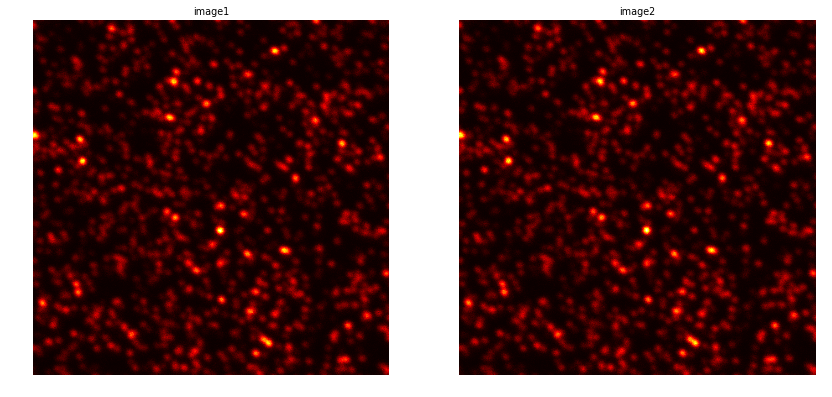

Image shape (1000, 1000) and pixel spacing [0.014999999700000006, 0.014999999700000006]


In [2]:
data_dir = "/Users/sami/Documents/Work/Data/2018_05_FSC_paper/Crimson_Beads_2D_FRC_Abberior"
image_name = "Confocal.tif"

# Get image
image1 = read.get_image(os.path.join(data_dir, image_name), channel=0)
image2 = read.get_image(os.path.join(data_dir, image_name), channel=1)

showim.display_2d_images(image1, image2)

print "Image shape {} and pixel spacing {}".format(image1.shape, image1.spacing)

## Setup FRC

The FRC execution can be modified in several ways, through the *argparse* interface that was originally developed for the command line scripts that was initially the intended UI for the *SuperTomo* package. 

In [3]:
import supertomo.ui.frc_options as options

data_dir = os.path.join(os.getcwd(), "data/2018_01_29_FRC_Nikon_Taka")
args_list = [data_dir, '--bin-delta=10', '--angle-delta=10', '--frc-curve-fit-degree=4', 
            '--resolution-threshold-criterion=one-bit', '--resolution-threshold-value=0.3', '--use-splines']

args = options.get_frc_script_options(args_list)

print args

Namespace(d_angle=10, d_bin=10, d_extract_angle=5.0, debug=False, directory='/Users/sami/Programming/GIT/supertomo2/notebooks/data/2018_01_29_FRC_Nikon_Taka', frc_curve_fit_degree=4, hanning=False, hollow_iterator=False, min_filter=False, pathout=None, resol_square=False, resolution_point_sigma=0.01, resolution_snr_value=0.5, resolution_threshold_criterion='one-bit', resolution_threshold_curve_fit_degree=3, resolution_threshold_value=0.3, use_splines=True)


## Run Regular Image FRC 

This will result into the FRC curve with the evident saturation effect.

In [4]:
data = FourierCorrelationDataCollection()


frc_task = frc.FRC(image1, image2, args.d_bin)
data[0] = frc_task.execute() 


analyzer = fsc_analysis.FourierCorrelationAnalysis(data, image1.spacing[0], args)
results = analyzer.execute()



Fit starts at 0.259999990463
Optimization terminated successfully.
         Current function value: 0.000052
         Iterations: 10
         Function evaluations: 20


## Filtered FRC

Here I do the same as above, but crop the beginning of the FRC curve, with 1.0 correlation values.

In [5]:
# Make image split
frc_task_crop = frc.FRC(image1, image2, args.d_bin)

# Run
frc_task_crop = frc.FRC(image1, image2, args.d_bin)
data2 = FourierCorrelationDataCollection()
data2[0] = frc_task_crop.execute()

data2[0] = crop_saturation_ridge(data2[0])

# Analyze and concatenate results
analyzer = fsc_analysis.FourierCorrelationAnalysis(data2, image1.spacing[0], args)
results2 = analyzer.execute()

results[1] = results2[0]


Fit starts at 0.159999996424
Optimization terminated successfully.
         Current function value: 0.000023
         Iterations: 11
         Function evaluations: 22


## Results

Cropping of the beginning of the FRC curve worked perfectly. It is interesting how saturation just simply shift the zero point to the right, but I suppose one can picture saturation as an edge that becomes blurred by the microscopes resolution -- the frequency shift is very interesting though. The same effect can be seen and corrected for in single images as well, by using the checkerboard split method.

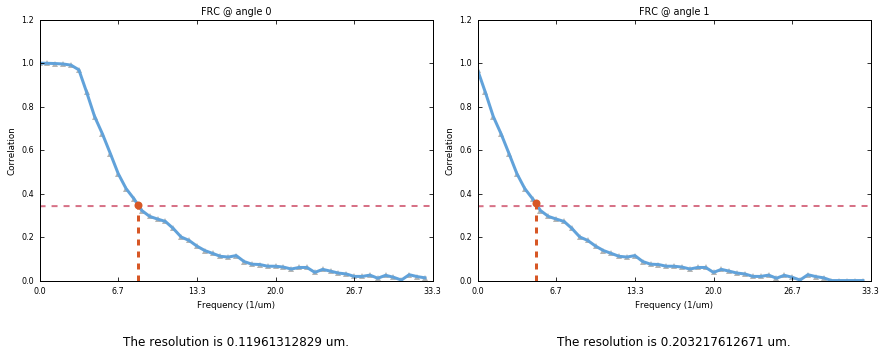

In [6]:
out_path = "/Users/sami/Documents/Work/Article manuscripts/2018_FRC:FSC/Data/Figure_Saturation"

plotter = frcplots.FourierDataPlotter(results, out_path)
plotter.plot_all()

In [7]:
#plotter.plot_all_to_files(custom_titles=("Saturated", "Corrected"))

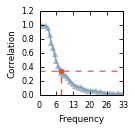

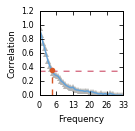

In [10]:
plotter.plot_one_to_file(0, "frc_beads_saturated", size=(1.5,1.5))

plotter.plot_one_to_file(1, "frc_beads_corrected", size=(1.5,1.5))

